In [243]:
#%pip install alpaca-py
#%pip install prophet

In [244]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd
import dateutil.parser as datetimeParser
import pickle
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet 

In [245]:
client = CryptoHistoricalDataClient()

In [246]:
current = datetime.now()
year_ago = current - timedelta(days=365) # using smaller timeframe for development
current_date = current.strftime("%Y-%m-%d")
year_ago_date = year_ago.strftime("%Y-%m-%d")


In [247]:
# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Day,
  start=year_ago_date,
  end=current_date
)

In [248]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
data = client.get_crypto_bars(request_params)

In [249]:
df = data.df

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 365 entries, ('BTC/USD', Timestamp('2023-04-10 05:00:00+0000', tz='UTC')) to ('BTC/USD', Timestamp('2024-04-08 05:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         365 non-null    float64
 1   high         365 non-null    float64
 2   low          365 non-null    float64
 3   close        365 non-null    float64
 4   volume       365 non-null    float64
 5   trade_count  365 non-null    float64
 6   vwap         365 non-null    float64
dtypes: float64(7)
memory usage: 32.2+ KB


In [251]:
df.head()


open          high           low  \
symbol  timestamp                                                         
BTC/USD 2023-04-10 05:00:00+00:00  28261.60  30442.560000  28155.309378   
        2023-04-11 05:00:00+00:00  30132.76  30566.970000  29810.740000   
        2023-04-12 05:00:00+00:00  29995.67  30500.000000  29698.050000   
        2023-04-13 05:00:00+00:00  30089.14  30931.007398  29844.948363   
        2023-04-14 05:00:00+00:00  30740.07  31049.990000  29989.960000   

                                          close        volume  trade_count  \
symbol  timestamp                                                            
BTC/USD 2023-04-10 05:00:00+00:00  30135.242250  11200.701133     162965.0   
        2023-04-11 05:00:00+00:00  29996.162800   8704.596567     134807.0   
        2023-04-12 05:00:00+00:00  30081.602642   6767.991584     143640.0   
        2023-04-13 05:00:00+00:00  30739.062565   8896.604315     176811.0   
        2023-04-14 05:00:00+00:00  30387.692417   9085.650685     177380.0   

                                           vwap  
symbol  timestamp                                
BTC/USD 2023-04-10 05:00:00+00:00  29309.728415  
        2023-04-11 05:00:00+00:00  30147.945190  
        2023-04-12 05:00:00+00:00  30058.615283  
        2023-04-13 05:00:00+00:00  30437.601831  
        2023-04-14 05:00:00+00:00  30514.500961

Mikä tähän valitaan ennustettavaksi? Aloitan nyt päivän huippuhinnalla

In [252]:
# Reset the index of the DataFrame
df.reset_index(inplace=True)

# Select the "timestamp" and "high" columns
df = df[["timestamp", "high"]]

# Remove timezone information from the timestamps in the "ds" column
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

df.head()

,timestamp,open
0,2023-04-10 05:00:00,28261.60
1,2023-04-11 05:00:00,30132.76
2,2023-04-12 05:00:00,29995.67
3,2023-04-13 05:00:00,30089.14
4,2023-04-14 05:00:00,30740.07


In [253]:
df.columns = ['ds','y']

df['ds'] = pd.to_datetime(df['ds'])
df.tail()

,ds,y
360,2024-04-04 05:00:00,65500.90
361,2024-04-05 05:00:00,67719.90
362,2024-04-06 05:00:00,67834.45
363,2024-04-07 05:00:00,69396.85
364,2024-04-08 05:00:00,69457.30


<Axes: xlabel='ds'>

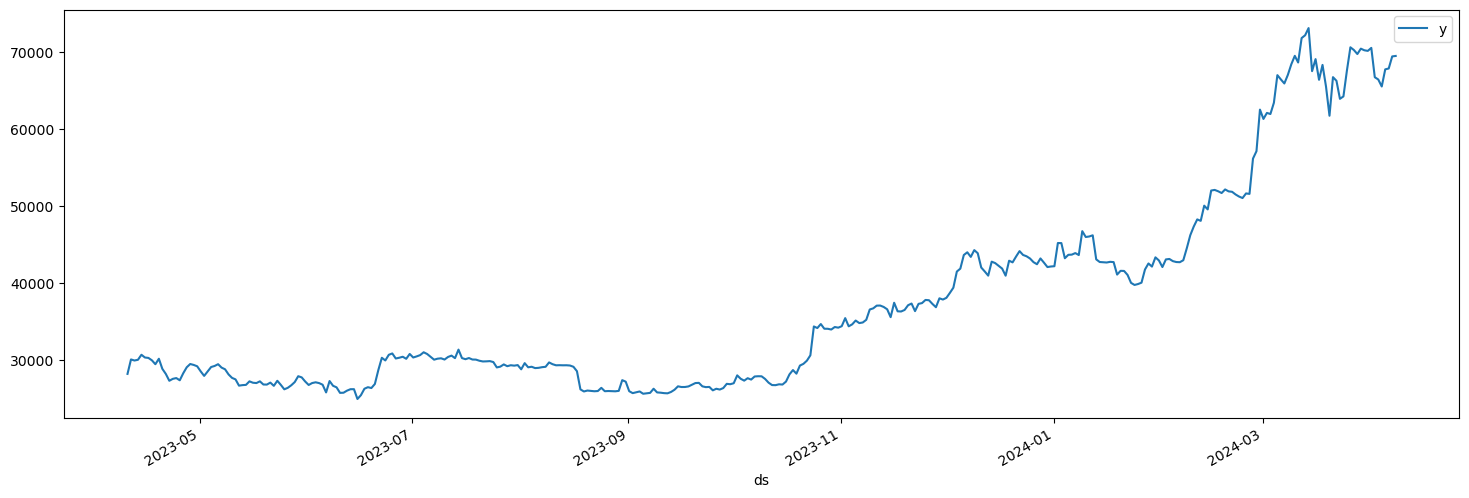

In [254]:
df.plot(x='ds',y='y',figsize=(18,6))

In [255]:
len(df)

365

In [256]:
testSplitSize=90

train = df.iloc[:len(df)-testSplitSize]
test = df.iloc[len(df)-testSplitSize:]

In [257]:

m = Prophet()
m.fit(train)
future = m.make_future_dataframe( periods=2400, freq='H') #MS for monthly, H for hourly
forecast = m.predict(future)

00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing


In [258]:

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2670,2024-04-18 02:00:00,62365.604931,54266.859303,70874.722748,54222.732767,70299.746258,162.555909,162.555909,162.555909,162.555909,162.555909,162.555909,0.0,0.0,0.0,62528.160839
2671,2024-04-18 03:00:00,62372.537622,54218.373584,70661.118714,54224.233567,70309.554062,163.451194,163.451194,163.451194,163.451194,163.451194,163.451194,0.0,0.0,0.0,62535.988816
2672,2024-04-18 04:00:00,62379.470313,54463.866909,70796.282358,54224.291423,70319.361867,163.948576,163.948576,163.948576,163.948576,163.948576,163.948576,0.0,0.0,0.0,62543.418889
2673,2024-04-18 05:00:00,62386.403005,54253.729936,70631.945480,54223.731394,70329.169672,164.009442,164.009442,164.009442,164.009442,164.009442,164.009442,0.0,0.0,0.0,62550.412447
2674,2024-04-18 06:00:00,62393.335696,54461.490349,70690.376431,54223.171366,70338.977477,163.598118,163.598118,163.598118,163.598118,163.598118,163.598118,0.0,0.0,0.0,62556.933815


In [259]:
test.tail()

,ds,y
360,2024-04-04 05:00:00,65500.90
361,2024-04-05 05:00:00,67719.90
362,2024-04-06 05:00:00,67834.45
363,2024-04-07 05:00:00,69396.85
364,2024-04-08 05:00:00,69457.30


In [260]:
plot_plotly(m ,forecast)

In [261]:
plot_components_plotly(m, forecast)

In [262]:
from statsmodels.tools.eval_measures import rmse

In [263]:


predictions = forecast.iloc[-testSplitSize:]['yhat']
     


In [264]:

print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  12855.083964741067
Mean Value of Test Dataset: 55485.43912222221
